In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


# Convolutional Neural networks 101

Convolutional neural networks are one of the most successful types of neural networks for image recognition and an integral part of the renewed interest in neural networks. 

In this lab we'll experiment with inserting 2D-convolutional layers in the fully connected neural networks from week1. We'll also experiment with multiple convolutional layers, max pooling and strided convolutions which are all important techniques in current architectures. Lastly we'll visualize the learned filters and understand what kind of features they learn.


If you are unfamilar with the the convolutional operation  https://github.com/vdumoulin/conv_arithmetic have a nice visualization of different convolutional variants. For a more in-dept tutorial please see http://cs231n.github.io/convolutional-networks/ or http://neuralnetworksanddeeplearning.com/chap6.html. Lastly if you are ambitious and eager to implement a convolutional neural network from scratch please cf. to an exercise for our Deep Learning summer school last year https://github.com/DTU-deeplearning/day2-Conv.

In [2]:
#LOAD the mnist data. To speed up training we'll only work on a subset of the data.
#Note that we reshape the data from (nsamples, num_features)= (nsamples, nchannels*rows*cols)  -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('../week1/mnist.npz')
num_classes = 10
nchannels,rows,cols = 1,28,28 # Since the MNIST dataset are greyscale, they only have 1 channel as compared to 3 for RGB images.
x_train = data['X_train'][:10000].astype('float32')
x_train = x_train.reshape((-1,nchannels,rows,cols))
targets_train = data['y_train'][:10000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1,nchannels,rows,cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1,nchannels,rows,cols))
targets_test = data['y_test'][:500].astype('int32')

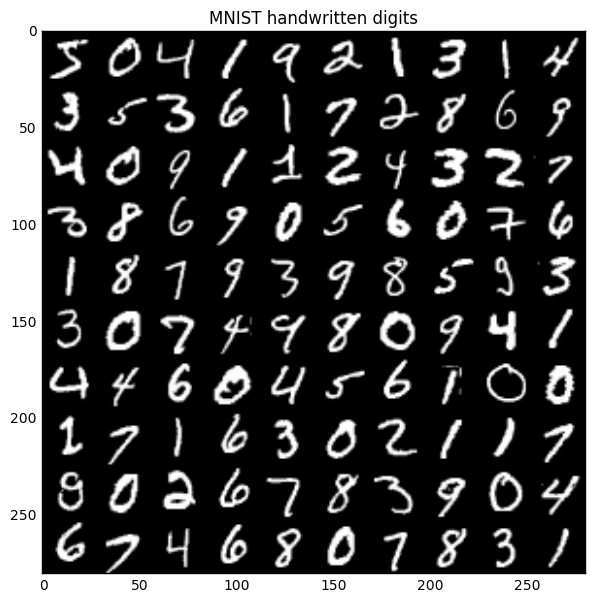

In [3]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

('l_out', (45, 10))
Epoch 1 : Train Loss 4.040421e-01 , Train acc 0.951300,  Valid acc 0.918000 
Epoch 2 : Train Loss 1.102757e-01 , Train acc 0.977900,  Valid acc 0.950000 
Epoch 3 : Train Loss 6.605184e-02 , Train acc 0.989500,  Valid acc 0.962000 
Epoch 4 : Train Loss 4.487953e-02 , Train acc 0.989400,  Valid acc 0.954000 
Epoch 5 : Train Loss 3.185948e-02 , Train acc 0.992700,  Valid acc 0.954000 
Epoch 6 : Train Loss 1.737934e-02 , Train acc 0.996400,  Valid acc 0.956000 
Epoch 7 : Train Loss 1.236433e-02 , Train acc 0.997500,  Valid acc 0.960000 
Epoch 8 : Train Loss 6.483161e-03 , Train acc 0.996700,  Valid acc 0.960000 
Epoch 9 : Train Loss 6.612379e-03 , Train acc 0.997900,  Valid acc 0.956000 
Epoch 10 : Train Loss 5.097056e-03 , Train acc 0.999100,  Valid acc 0.960000 

Test set Acc:  0.978000


(<matplotlib.text.Text at 0x7fc1c3d0b250>,
 (0.75, 1.03))

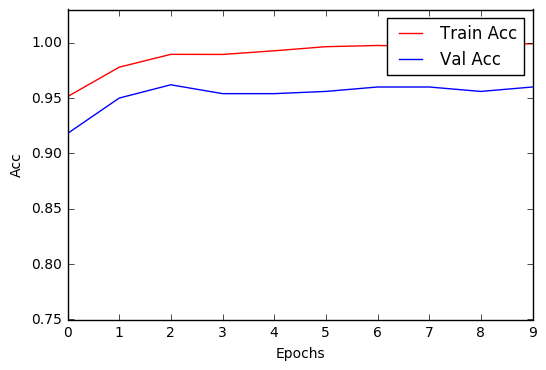

In [4]:
#Define a simple feed forward neural network
from lasagne.nonlinearities import leaky_rectify, softmax, tanh
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, DropoutLayer, MaxPool2DLayer, BatchNormLayer

#Somehow it does not know elu, so I am defining it myself:
def elu(x):
    return theano.tensor.switch(x>0,x,theano.tensor.exp(x)-1)

#And batch_norm!?!?!?:
def batch_norm(layer, **kwargs):
    nonlinearity = getattr(layer, 'nonlinearity', None)
    if nonlinearity is not None:
        layer.nonlinearity = nonlinearities.identity
    if hasattr(layer, 'b') and layer.b is not None:
        del layer.params[layer.b]
        layer.b = None
    bn_name = (kwargs.pop('name', None) or
               (getattr(layer, 'name', None) and layer.name + '_bn'))
    layer = BatchNormLayer(layer, name=bn_name, **kwargs)
    if nonlinearity is not None:
        from .special import NonlinearityLayer
        nonlin_name = bn_name and bn_name + '_nonlin'
        layer = NonlinearityLayer(layer, nonlinearity, name=nonlin_name)
    return layer

#defined the model
num_class = 10
num_features = x_train.shape[1]

l_in = InputLayer(shape=(None,nchannels,rows,cols)) #note that we use a 4D input since we need to retain the spatial arrangement of the pixels when working with convolutions.
l_conv = Conv2DLayer(l_in,num_filters=16,filter_size=5)
#l_pool1 = MaxPool2DLayer(l_conv,pool_size=(2,2))
#l_norm = BatchNormLayer(l_pool1)
l_conv1 = Conv2DLayer(l_conv,num_filters=20,filter_size=5)
#l_pool2 = MaxPool2DLayer(l_conv1,pool_size=(2,2))
#l_norm1 = BatchNormLayer(l_pool2)
l_hid = DenseLayer(l_conv1, num_units=100, nonlinearity=elu) #remember to connect the new conv-layer here
#l_dropout = DropoutLayer(l_hid,p=0.2)

l_out = DenseLayer(l_hid, num_units=num_class, nonlinearity=softmax)

#Setting up the graph in theano
sym_x = T.tensor4('sym_x') # a symbolic variable, this is now a 4-D tensor.
sym_t = T.ivector('sym_t') # a symbolic variable taking on the value of the target batch.

# Retrieve network output
train_out = lasagne.layers.get_output(l_out, sym_x, deterministic=False)
eval_out = lasagne.layers.get_output(l_out, sym_x, deterministic=True)

# Retrieve list of all trainable parameters in the network.
all_params = lasagne.layers.get_all_params(l_out, trainable=True)

cost = T.nnet.categorical_crossentropy(train_out+1e-8, sym_t).mean()

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(cost, all_params)

# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=0.001)

f_eval = theano.function([sym_x],
                     eval_out, on_unused_input='warn')

f_train = theano.function([sym_x, sym_t],
                          [cost],
                          updates=updates, on_unused_input='warn')

#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

model = lasagne.layers.get_output(l_out, sym_x)
out = model.eval({sym_x:x}) #this could also include mask etc if used
print("l_out", out.shape)

#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]    
            batch_loss = f_train(x_batch,target_batch) #this will do the complete backprob pass
            cur_loss += batch_loss[0]
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            net_out = f_eval(x_batch)   
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
net_out = f_eval(x_test)    
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments 1

 1) Evaluate the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 
 
 2) Can the performance be increased even further by stacking more convolutional layers?
 
 3) Maxpooling is a technique for decreasing the spatial resolution of an image while maintaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. Try to: 
 
     a) add a maxpool layer(add arguement pool_size=2)  after the convolution layer or
 
     b) add stride=2 to the arguments of the convolution layer. 

Verify that this decreases spatial dimension of the image. (print l_conv.output_shape or print   l_maxpool.output_shape). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?
  


# 1)
With 30 epochs the standard feedforward net produces an validation accuracy of 93%.
### 16 filters, 5x5
Produces validation accuracy of 94.8% but seems to overfit the data
### 20 filters, 5x5
After some experimenting I found that this give validation accuracy of 95.6%. The overfitting is still present though.

# 2)
Using 16x5x5 and 20x5x5 I obtained a validation accuracy of 95.8% which is only .2% better than with 1 conv layer. Training took ~15 mins, so I am not really encouraged to play too much with this.




# 3)
Using a pooling layer decreases the spatial resolution of an image as seen below

In [6]:
print "Convolution layer output: {}".format(l_conv.output_shape)
print "Max pool layer output: {}".format(l_pool1.output_shape)

Convolution layer output: (None, 16, 24, 24)


NameError: name 'l_pool1' is not defined

And by having the architecture: conv_16x5x5, pool_2x2, conv_20x3x3, pool_2x2 it took only ~2 mins to train on the CPU and obtained an validation accuracy of 97.2% and shows no tendensy to overfit! Amazing!

# Visualization of filters
Convolutional filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc. Below we provide code for visualization of the filters. The best results are obtained with fairly large filters of size 9 and either 16 or 36 filters. 

(16, 1, 5, 5) i.e. the shape is num_filters, num_channels, filter_size, filter_size
learned filter values


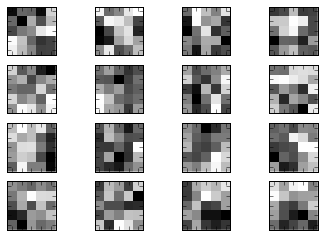

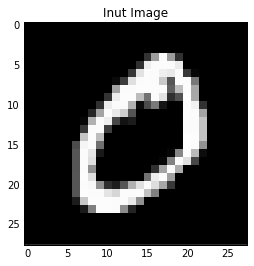

Response from input image convolved with the filters


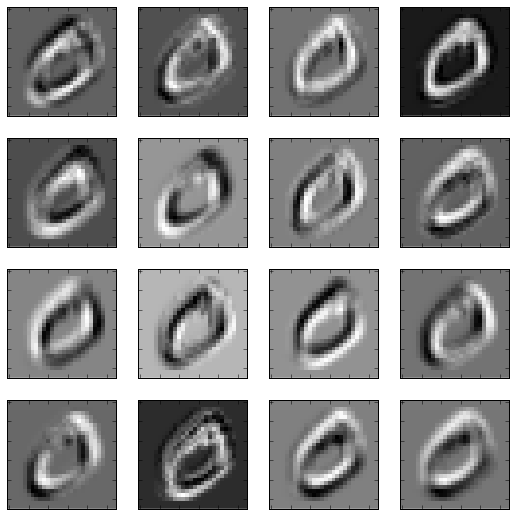

In [7]:
### If you get an error with l_conv not being defined you need to define l_conv when the network is defined!
np_W = l_conv.W.get_value() #get the filter values from the conv layer
print np_W.shape, "i.e. the shape is num_filters, num_channels, filter_size, filter_size"
num_filters,num_channels,filter_size,_= np_W.shape
n = int(num_filters**0.5)

np_W_res = np_W.reshape(n,n,num_channels,filter_size,filter_size)
fig, ax = plt.subplots(n,n)
print "learned filter values"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(np_W_res[i,j,0], cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())


idx = 1
plt.figure()
plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
plt.title('Inut Image')
plt.show()

#visalize the filters convolved with an input image
from scipy.signal import convolve2d
np_W_res = np_W.reshape(n,n,num_channels,filter_size,filter_size)
fig, ax = plt.subplots(n,n,figsize=(9,9))
print "Response from input image convolved with the filters"
for i in range(n):
    for j in range(n):
        ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[i,j,0],mode='same'), cmap='gray',interpolation='none')
        ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
        ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())



# Assignment 2

The visualized filters will likely be very noisy due to the small amount of training data.

 1) Try to use 10000 training examples instead and visualise the filters again.
 
 2) Dropout is a very useful technique for preventing overfitting. Add a DropoutLayer after the convolutional layer and hidden layer. This should increase both performance and the "visual appeal" of the filters.
 
 3) Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 

# 1)

In [8]:
print x_train.shape

(10000, 1, 28, 28)


# 2)
Dropout is added after conv_layer and hid_layer with p=0.2. It increased the performance of the net, but the visualization does not seemed to be changed much.

# 3)
I tried to insert batch norm layers in the network above, however it not give better results than the validation accuracy of 97.2% I obtained first.

# More Fun with convolutional networks
### Dataset

Here each mnist digit (20x20 pixels) has been placed randomly in a 60x60 canvas. To make the task harder each canvas has then been cluttered with small pieces of digits. In this task it the network needs to focus only on the digit and ignore the rest.

The ``TransformerLayer`` lets us do this. The transformer layer learns an affine transformation which lets the network zoom, rotate and skew. If you are interested you should read the paper, but the main idea is that you can let a small convolutional network determine the the parameters of the affine transformation. You then apply the affine transformation to the input data. Usually this also involves downsampling, which forces the model to zoom in on the relevant parts of the data. After the affine transformation we can use a larger convolutional network for classification. 
This is possible because you can backprop through an affine transformation if you use bilinear interpolation.

In [9]:
import os
import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T

conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


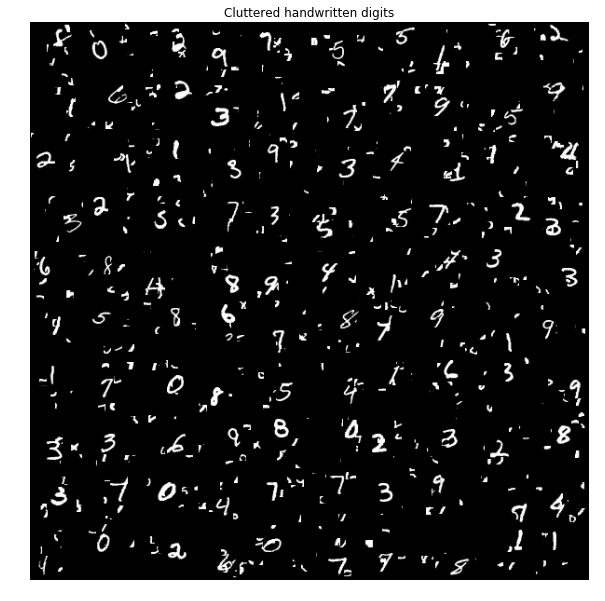

In [10]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=lasagne.utils.floatX(X_train),
        y_train=y_train.astype('int32'),
        X_valid=lasagne.utils.floatX(X_valid),
        y_valid=y_valid.astype('int32'),
        X_test=lasagne.utils.floatX(X_test),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

idx = 0
canvas = np.zeros((DIM*10, 10*DIM))
for i in range(10):
    for j in range(10):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

## Building the model

We use a model where the localization network is a two layer convolutional network operating directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation.

The transformer layer is initialized for the identity transformation, similarly to [1]. If the output from the localization networks is [t1, t2, t3, t4, t5, t6] then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and t6 moves the center position. By setting the initial values of the bias vector to 

```
|1, 0, 0|
|0, 1, 0|
```
and the final W of the localization network to all zeros we ensure that in the beginning of training the network works as a pooling layer.

The output of the localization layer feeds into the transformer layer, which applies the transformation to the image input. In our setup the transformer layer downsamples the input by a factor 3.

Finally a 2 layer convolutional layer and 2 fully connected layers calculates the output probabilities.


### The model
```
Input -> localization_network -> TransformerLayer -> output_network -> predictions
   |                                |
   >--------------------------------^
```




In [11]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=8, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=8, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, loc_out, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=16,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out, l_trans1

model, l_transform = build_model(DIM, DIM, NUM_CLASSES)
model_params = lasagne.layers.get_all_params(model, trainable=True)


Transformer network output shape:  (None, 1, 20, 20)


In [12]:
X = T.tensor4()
y = T.ivector()

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates)
eval = theano.function([X], [output_eval, transform_eval])

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Training the model
Unfortunately NVIDIA have yet to squeeze a TitanX into a laptop; hence training convnets on CPU is painfully slow. After 10 epochs you should see that model starts to zoom in on the digits. 

In [13]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)
    print ""
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

In [14]:
valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
Epoch 0: Train cost 2.25857830048, Train acc 0.13994, val acc 0.256, test acc 0.249
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
Epoch 1: Train cost 1.63511502743, Train acc 0.42706, val acc 0.5783, test acc 0.5798
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
Epoch 2: Train cost 1.00177502632, Train acc 0.67058, val acc 0.717, test acc 0.7236
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
Epoch 3: Train cost 0.764460325241, Train acc 0.75116, val acc 0.7827, test acc 0.7869
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 
Epoch 4: Train cost 0.648663163185, Train acc 0.7911, val acc 0.7882, test acc 0.7881
0 10 20 30 40 50 60 70 80 90 100 110 120


### Plot errors and zoom

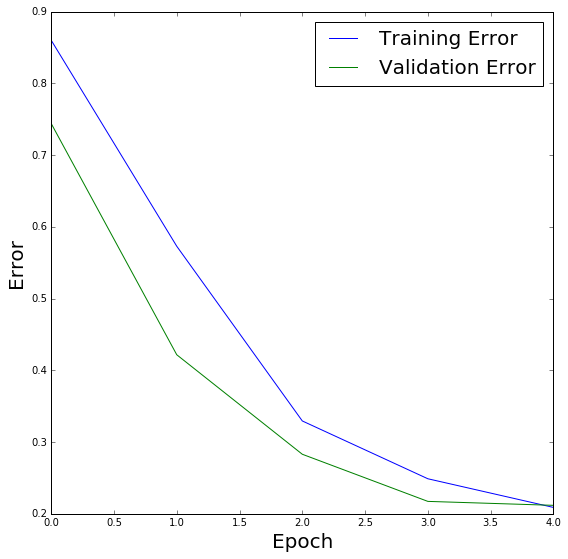

In [15]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

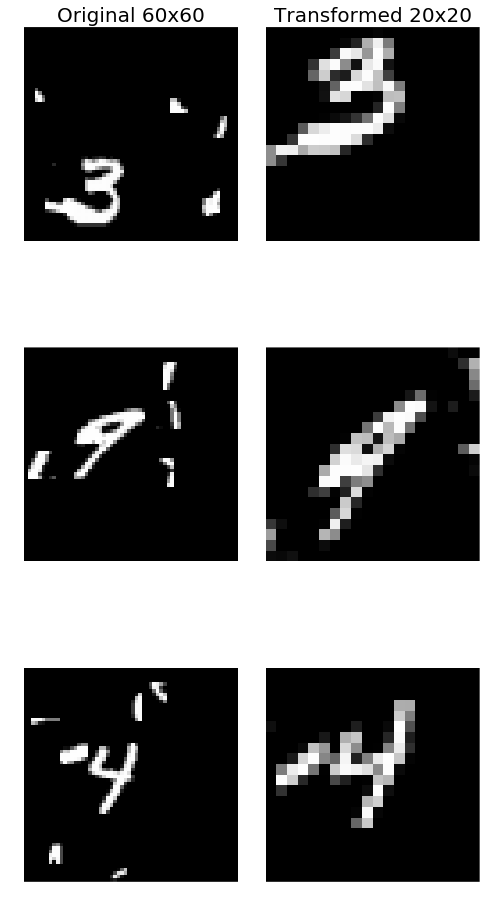

In [16]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
    
    
plt.tight_layout()

In [17]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.231520 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


# A few pointers for image classification
Performing image classification with a pretrained model is often a good choice, especially if you have a limited amount of labeled data. 

An often used pretrained network is the VGG16 and VGG19. Lasagne has pretrained models in the [modelzoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo). Torch7 and Tensorflow have similar pretrained models that you can find on Google. 

Currently the best performing image networks are [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf). Torch7 has an interesting blog post on Residual nets. http://torch.ch/blog/2016/02/04/resnets.html


